<a href="https://colab.research.google.com/github/neddy0318/neddy_space/blob/main/%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay #주식 예측 시평일만 카운트 해주기 위함
!pip install currencyconverter #API로 환전
from currency_converter import CurrencyConverter
from sklearn.metrics import mean_squared_error


plt.style.use('fivethirtyeight')




In [1]:

def showmetheprophet(corp_name, 원화투자금):           #원화 금액 입력하면 환전
  current_datetime = datetime.now().strftime("%Y-%m-%d")
  start_year = datetime.now().year - 5         # 현재 기준 5년 전까지의 데이터 사용
  start_datetime = datetime.now().replace(year=start_year)
  start_date_str = start_datetime.strftime("%Y-%m-%d")
  corp = yf.download(corp_name, start=start_date_str, end=current_datetime) #입력 날짜 기준으로 주식 데이터 다운로드
  corp['ds'] = pd.to_datetime(corp.index, format = '%Y-%m-%d')
  corp['y'] = corp['Adj Close']                           #조정 마감가를 y에 할당
  corp_train = corp[['ds', 'y']][:-251]

  #모델 적합

  model_prophet = Prophet(changepoint_prior_scale = 0.15, daily_seasonality = True, seasonality_mode='multiplicative', n_changepoints=100, seasonality_prior_scale=0.05)

  model_prophet.fit(corp)

  #향후 1년간의 time stamp 생성

  fcast_time_with_weekends = 365 #365일 예측
  corp_forecast = model_prophet.make_future_dataframe(periods=fcast_time_with_weekends, freq='D')

  # 주말을 제외한 날짜 범위 생성
  corp_forecast['exclude_weekend'] = corp_forecast['ds'] + BDay(0)
  corp_forecast = corp_forecast[corp_forecast['ds'].dt.weekday < 5]
  corp_forecast = model_prophet.predict(corp_forecast)
  model_prophet.plot(corp_forecast, xlabel = 'Date', ylabel= 'adj price($)')
  plt.show()

  #투자금에 따른 주식 구매량 및 수익률

  #0)환전
  cc = CurrencyConverter()
  dollor = round(cc.convert(원화투자금, 'KRW', 'USD'), 0)

  #1)입력한 현재 날짜 기준 금액 구하기
  current_price = corp_forecast.query('ds == @current_datetime').iloc[0]['yhat']
  #주문가능 수량 및 잔여금
  amount = dollor//current_price
  purchasable_price = round(amount*current_price, 2)
  residue = round(dollor%current_price,2)
  print("현재 날짜 기준 주문 가능 수량은 약", amount, "개이며, 총", purchasable_price, "달러입니다. 잔여금은", residue, "달러입니다")

  #예상 수익(평균) 및 수익률(평균)
  avg_f_price = corp_forecast.iloc[-1]['yhat']    #yhat칼럼의 맨 마지막 행 값 가져오기
  expected_avg_total_price = round(amount*avg_f_price,2)
  expected_avg_profit = round(expected_avg_total_price-purchasable_price, 2)
  avg_profit_percentage = round((avg_f_price-current_price)/current_price*100, 2)
  print("1년 후 총금액의 예상 평균치는", expected_avg_total_price, '달러이며, 그에 따른 수익은', expected_avg_profit, '입니다. 예상 수익률은', avg_profit_percentage, '% 입니다.' )

  #예상 수익(최대) 및 수익률(최대)
  upper_f_price = corp_forecast.iloc[-1]['yhat_upper']    #yhat칼럼의 맨 마지막 행 값 가져오기
  expected_upper_total_price = round(amount*upper_f_price,2)
  expected_upper_profit = round(expected_upper_total_price-purchasable_price, 2)
  upper_profit_percentage = round((upper_f_price-current_price)/current_price*100, 2)
  print("1년 후 총금액의 예상 최대치는", expected_upper_total_price, '달러이며, 그에 따른 수익은', expected_upper_profit, '입니다. 예상 수익률은', upper_profit_percentage, '% 입니다.' )

  #예상 수익(최저) 및 수익률(최저)
  lower_f_price = corp_forecast.iloc[-1]['yhat_lower']    #yhat칼럼의 맨 마지막 행 값 가져오기
  expected_lower_total_price = round(amount*lower_f_price,2)
  expected_lower_profit = round(expected_lower_total_price-purchasable_price, 2)
  lower_profit_percentage = round((lower_f_price-current_price)/current_price*100, 2)
  print("1년 후 총금액의 예상 최저치는", expected_lower_total_price, '달러이며, 그에 따른 수익은', expected_lower_profit, '입니다. 예상 수익률은', lower_profit_percentage, '% 입니다.' )

  #예측력 테스트
  #기존 데이터의 마지막 1년을 test용으로 할당
  corp_test = corp[-251:]


  # 예측
  future = corp_test[['ds']]  # 테스트 데이터의 날짜 칼럼을 그대로 사용하여 future 데이터프레임 생성
  forecast = model_prophet.predict(future)

  # 평가
  y_pred = forecast['yhat'].values
  y_true = corp_test['y'].values
  mae = mean_absolute_error(y_true, y_pred)
  print('   ')
  print('<예측력 평가 지표 및 Train 데이터-Test데이터 비교 그래프>')
  print('MAE: %.3f' % mae)
  mse = mean_squared_error(y_true, y_pred)
  print('MSE: %.3f' % mse)

  rmse = np.sqrt(mse)
  print('RMSE: %.3f' % rmse)


  plt.plot(y_true, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.title('Predictability Test')
  plt.legend()
  plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.4/588.4 kB 8.1 MB/s eta 0:00:00


[*********************100%%**********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmppemprrbf/xslov9ru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppemprrbf/ys_nijvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85783', 'data', 'file=/tmp/tmppemprrbf/xslov9ru.json', 'init=/tmp/tmppemprrbf/ys_nijvk.json', 'output', 'file=/tmp/tmppemprrbf/prophet_model60knvou2/prophet_model-20240313013042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:30:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


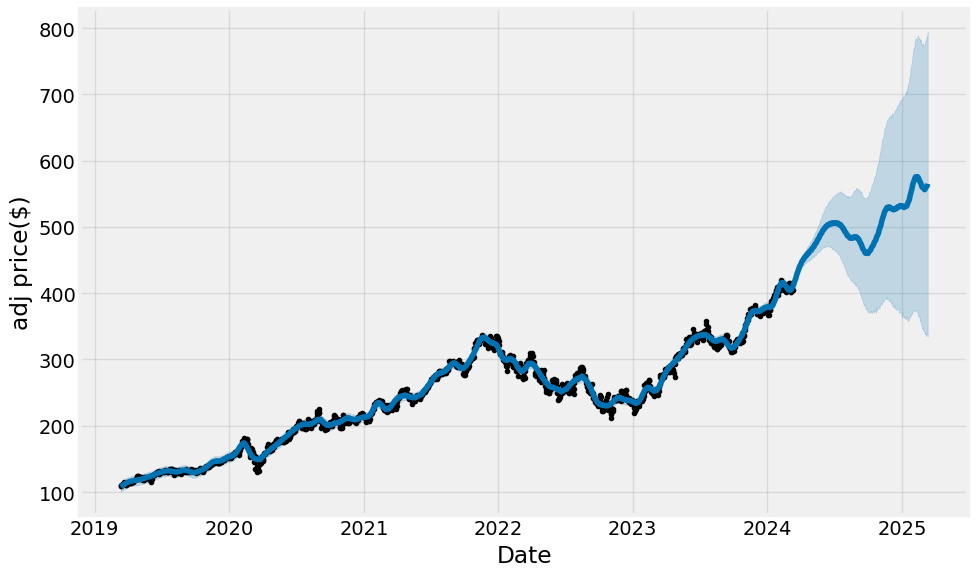

현재 날짜 기준 주문 가능 수량은 약 18.0 개이며, 총 7436.41 달러입니다. 잔여금은 52.59 달러입니다
1년 후 총금액의 예상 평균치는 10170.35 달러이며, 그에 따른 수익은 2733.94 입니다. 예상 수익률은 36.76 % 입니다.
1년 후 총금액의 예상 최대치는 14293.91 달러이며, 그에 따른 수익은 6857.5 입니다. 예상 수익률은 92.22 % 입니다.
1년 후 총금액의 예상 최저치는 6025.79 달러이며, 그에 따른 수익은 -1410.62 입니다. 예상 수익률은 -18.97 % 입니다.
   
<예측력 평가 지표 및 Train 데이터-Test데이터 비교 그래프>
MAE: 5.150
MSE: 40.338
RMSE: 6.351


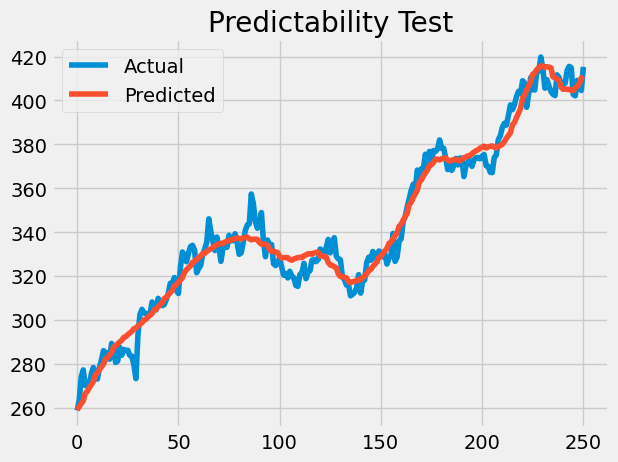

In [2]:
#예시

showmetheprophet('MSFT', 10000000)